# Data Import
[Coding Prompt](https://github.com/immunitastx/coding_exercises)

My approach here is to load in the two datasets directly into pandas dataframes and manipulate the data frome there.

In [ ]:
import pandas as pd
from google.colab import userdata

# set path variables here
conditions_path = userdata.get('conditions_path')
omics_path = userdata.get('omics_path')

conditions = pd.read_csv(conditions_path, sep="\t", compression="gzip")
omics = pd.read_csv(omics_path, sep="\t", compression="gzip")

# Initial Look at Datasets
First we just want to look at the two datasets to understand how they are structured.

In [ ]:
conditions.head()

,Unnamed: 0,condition
0,cell_0,condition_1
1,cell_1,condition_1
2,cell_2,condition_1
3,cell_3,condition_1
4,cell_4,condition_1


In [22]:
omics.iloc[:, : 5].head()

,Unnamed: 0,gene_0,gene_1,gene_2,gene_3
0,cell_0,8.629958,10.982940,7.266632,10.678859
1,cell_1,14.184409,5.969177,9.096169,5.425243
2,cell_2,7.921721,13.514010,9.889723,8.975386
3,cell_3,10.054261,13.074895,10.282566,12.702361
4,cell_4,14.482753,10.483962,4.408518,8.481078


# Annotate Cells and Calculate Differences

Since the conditions dataframe contains the annotations for the experimental conditions, we will merge the two dataframes together in order to annotate each of the cells by their associated condition.  

From there, we want to ask the question of whether or not gene levels significantly changed between the two conditions. The approach to test this is as follows:
1. Get list of genes
2. Iterate through this list
3. For each iteration, perform a t-test to calculate p-val
4. Track each gene and associated p-val

In [46]:
# merge dataframes to annotate cells
df = conditions.merge(omics, on="Unnamed: 0")
df.rename(columns={'Unnamed: 0': 'cell'}, inplace=True)

from scipy.stats import ttest_ind

gene_stats = {'Gene': [], 'p': []}

# 1. Get list of genes
genes = [col for col in df if col.startswith('gene')]

# 2. Iterate through gene list
for gene in genes:
    # 3. For each iteration, perform a t-test to calculate p-val
    t_stat, p_val = ttest_ind(
        df[df.condition == 'condition_1'][gene],
        df[df.condition == 'condition_2'][gene])

    # 4. Track each gene and associated p-val
    gene_stats['Gene'] += [gene]
    gene_stats['p'] += [p_val]

gene_stats = pd.DataFrame(gene_stats)

# Multiple Testing Correction

We just made a large number of significance tests, so we should now correct for this. Here I am using Benjamini-Hochberg to correct each p-value which should be appropriate for the large number of tests.  

We will look at both the uncorrected and corrected data as a quality check.

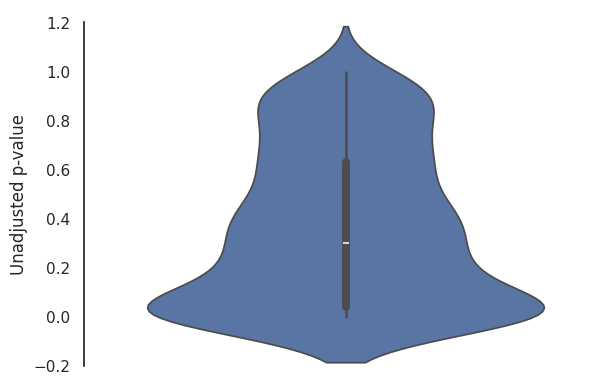

In [89]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()
sns.set_style('white')

# plot data prior to bh correction
plt.figure()
sns.violinplot(gene_stats.p)

plt.ylabel('Unadjusted p-value')
sns.despine(offset=10, trim=True, bottom=False)

plt.show()

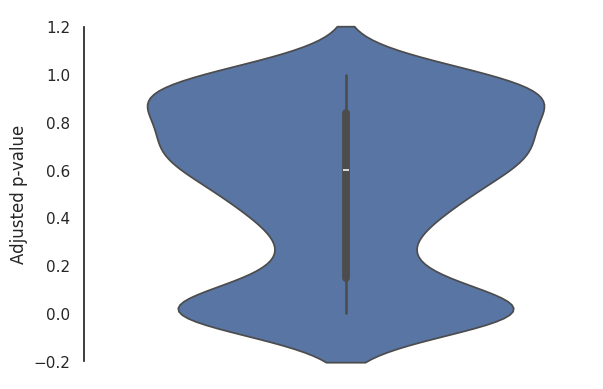

In [88]:
from statsmodels.stats.multitest import multipletests

# bh correction and plotting of adjusted data
gene_stats['adjusted_p'] = multipletests(gene_stats['p'], method='fdr_bh')[1]

plt.figure()
sns.violinplot(gene_stats.adjusted_p)

plt.ylabel('Adjusted p-value')
sns.despine(offset=10, trim=True, bottom=False)

plt.show()

# Classify Significant Genes

We can see that the BH adjusted p-value distribution is nicely bimodal, allowing us easily identify those genes that experience significant change between the two conditions.  

Typically, for a first look at a dataset like this it is fine to use a p < 0.05 as a significance cutoff, but in the plot below we can see sparsity in the dataset between 0.1 > p > 0.01, and a large concentration of data points below p < 0.01.

Text(0.5, 0, '')

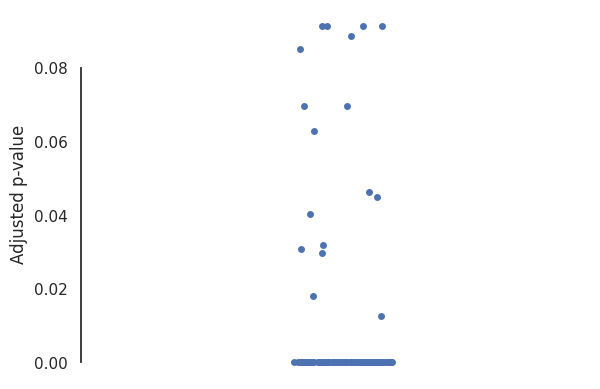

In [97]:
results_df_melted = gene_stats.melt(id_vars=['Gene'], value_vars=['adjusted_p'], var_name='p_type', value_name='p_value')
results_df_melted.head()

plt.figure()
sns.stripplot(data=results_df_melted[results_df_melted.p_value < 0.1], x='p_type', y='p_value')

sns.despine(offset=10, trim=True, bottom=False)
plt.ylabel('Adjusted p-value')
plt.xticks([])
plt.xlabel('')

Because of the sparsity we see in the above plot above p = 0.01, it seems reasonable to use p < 0.01 as our adjusted threshold of significance.  

We therefore filter by this signficance and return the list of passing genes.

In [79]:
significant_genes = gene_stats[gene_stats['adjusted_p'] < 0.01]
significant_genes.sort_values('adjusted_p').Gene.to_list()

['gene_243',
 'gene_76',
 'gene_389',
 'gene_297',
 'gene_446',
 'gene_226',
 'gene_498',
 'gene_280',
 'gene_265',
 'gene_132',
 'gene_451',
 'gene_12',
 'gene_334',
 'gene_25',
 'gene_461',
 'gene_322',
 'gene_142',
 'gene_426',
 'gene_268',
 'gene_71',
 'gene_349',
 'gene_74',
 'gene_137',
 'gene_454',
 'gene_274',
 'gene_116',
 'gene_242',
 'gene_222',
 'gene_33',
 'gene_246',
 'gene_419',
 'gene_240',
 'gene_499',
 'gene_161',
 'gene_130',
 'gene_409',
 'gene_275',
 'gene_147',
 'gene_22',
 'gene_81',
 'gene_107',
 'gene_181',
 'gene_171',
 'gene_352',
 'gene_332',
 'gene_122',
 'gene_119',
 'gene_294',
 'gene_16',
 'gene_175',
 'gene_381',
 'gene_197',
 'gene_384',
 'gene_304',
 'gene_470',
 'gene_183',
 'gene_255',
 'gene_214',
 'gene_354',
 'gene_200',
 'gene_176',
 'gene_363',
 'gene_356',
 'gene_148',
 'gene_466',
 'gene_195',
 'gene_311',
 'gene_477',
 'gene_96',
 'gene_261',
 'gene_293',
 'gene_227',
 'gene_292',
 'gene_374',
 'gene_321',
 'gene_399',
 'gene_314',
 'gene_27